#Introduction

In this notebook I will be forecasting mean temperature during the day in Delhi India using NeuralProphet.

I will be using this dataset https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data 

In [ ]:
%%capture
!pip install pystan~=2.14
!pip install git+https://github.com/ourownstory/neural_prophet.git
!pip install plotly --upgrade

In [ ]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet, set_log_level
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error
import ast
import pickle

#Exploring the data


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/time_series_data/DailyDelhiClimateTrain.csv', parse_dates=[0])
df_test = pd.read_csv('/content/drive/MyDrive/time_series_data/DailyDelhiClimateTest.csv', parse_dates=[0])

In [ ]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
df.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [ ]:
df_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [ ]:
df_test.tail()

,date,meantemp,humidity,wind_speed,meanpressure
109,2017-04-20,34.500,27.500000,5.562500,998.625000
110,2017-04-21,34.250,39.375000,6.962500,999.875000
111,2017-04-22,32.900,40.900000,8.890000,1001.600000
112,2017-04-23,32.875,27.500000,9.962500,1002.125000
113,2017-04-24,32.000,27.142857,12.157143,1004.142857


Each row of data is daily mean of four measurments. Data starts at 2013-01-01 and ends at 2017-04-24. It was split into train and test set but I will combined it into one dataframe. Last row of train df and first row of test df contain information about the same day so I'm going to drop train df's last row.

In [ ]:
df = df[:-1]

In [ ]:
df = pd.concat([df, df_test], axis=0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1575 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1575 non-null   datetime64[ns]
 1   meantemp      1575 non-null   float64       
 2   humidity      1575 non-null   float64       
 3   wind_speed    1575 non-null   float64       
 4   meanpressure  1575 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 73.8 KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
meantemp,1575.0,25.231582,7.337316,6.000000,18.516667,27.166667,31.142857,38.714286
humidity,1575.0,60.420115,16.956083,13.428571,49.750000,62.380952,72.125000,98.000000
wind_speed,1575.0,6.903642,4.508803,0.000000,3.700000,6.370000,9.262500,42.220000
meanpressure,1575.0,1010.589745,175.298310,-3.041667,1001.875000,1009.000000,1015.183333,7679.333333


There is a clearly visible yearly seasonality which is no surprise. Observations are noisy but I can see some repeating patterns that autoregressive part of NeuralProphet might by able to learn.

In [ ]:
fig = px.line(df, x='date', y='meantemp')
fig.show()

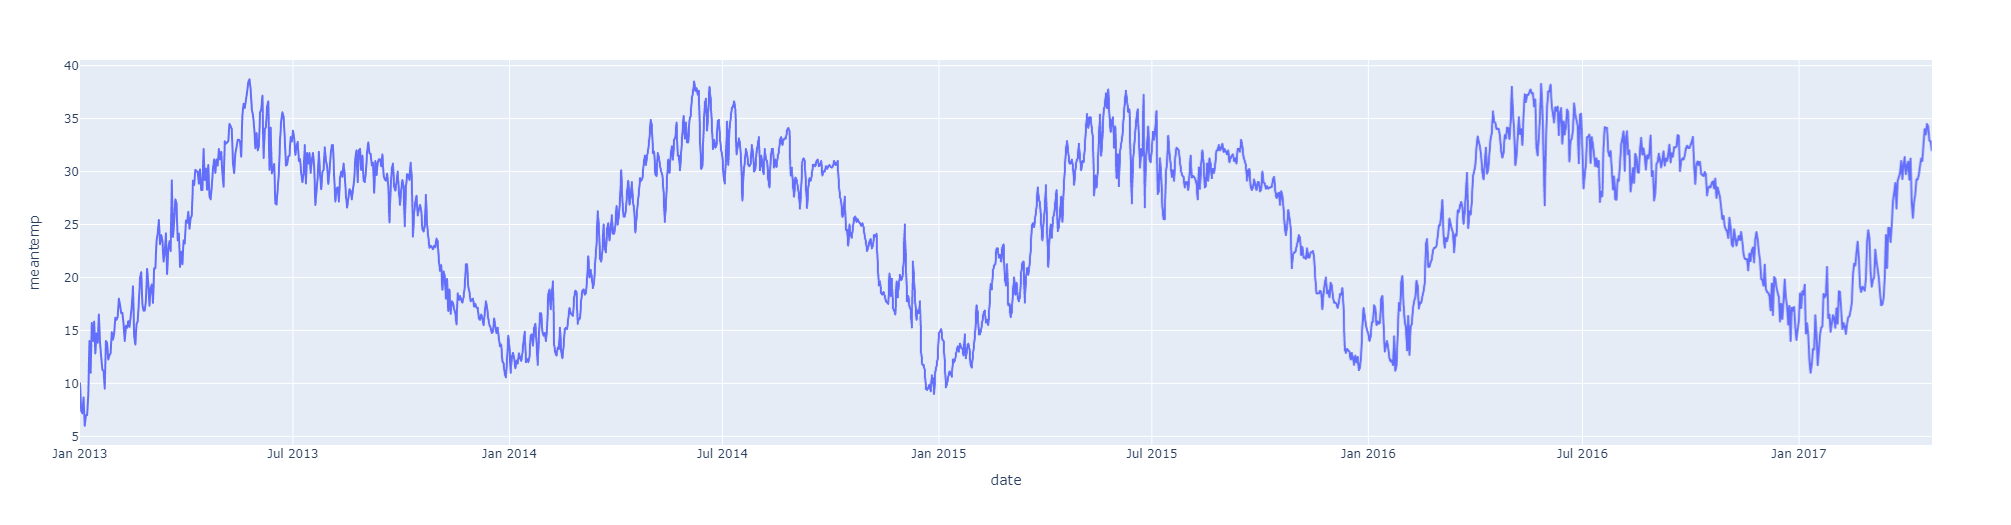

In [ ]:
npdf = df[['date', 'meantemp']]
npdf.columns = ['ds', 'y']
npdf.head()

,ds,y
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000


Here is a function for crossvalidation. 

When working with sequential data standard crossvalidation doesn't make sense. For sequential data crossvalidation should work like this: 

Fold 1. you take first 70% of data as training and following 5% as testing data

Fold 2. first 75% of data is training data and following 5% is testing data and so on.

My function works just like that but size of testing data is expressed as number of steps not percents. Training and testing metrics are returned. Function also returns forecast from each fold plotted against ground truth values and prophet object fitted during last fold.

NeuralProphet provides method for testing it's performance but it's not specified in the documentation how exacly metrics are calculated. I decided not tu use it because I was concerned that I wouldn't get fair comparison of models predicting 30 steps ahead at once and models predicting only 1 step ahead and then using this prediction to obtain next prediction. NeuralProphet's test function requires ground truth values and I suspect that when it's evaluating  model that predicts 1 step into future at a time on 30 steps window it uses ground truth value from 1 step to predict step 2 when I want it to use predicted value for step 1. To ensure fair comparison my function uses predict method that isn't supplied with gt values so there is no possibility of data leakage.

In [ ]:
def crossvalidate(params, data_df, metrics_train=None, metrics_test=None, forecast_steps=30, n_folds=5, freq='D', exp_name='experiment', gt_pct=0.3):
    
    columns=["MAE", "RMSE", 'Params']

    #parameter to determine if forecast need to be done using auto regression
    if forecast_steps == params['n_forecasts']:
      ar_forecast = False
    else:
      ar_forecast = True
    
    #creating dataframes for metrics if not provided
    if type(metrics_train) == type(None):
      metrics_train = pd.DataFrame(columns=["MAE", "RMSE"])
    if type(metrics_test) == type(None):
      metrics_test = pd.DataFrame(columns=columns)

    #if n_lags is not provided all forecasted values will be in the same column 
    #if it is provided they will be in separate columns     
    try:
      params['n_lags']
    except:
      yhats_cols = ['yhat1']
    else:
      yhats_cols = [f'yhat{i}' for i in range(1, params['n_forecasts']+1)]

    fig = go.Figure()

    #zooms in on selected percentage of data
    gt_offset = int(len(data_df) * (1- gt_pct))

    fig.add_trace(go.Scatter(x=data_df[gt_offset:]['ds'], y=data_df[gt_offset:]['y'], mode='lines', name='ground truth'))

    for i, fold in enumerate(range(n_folds, 0, -1)):
      #creating train and test splits for each fold
      if i+1 == n_folds:
        df_test = data_df[-forecast_steps*fold:]
      else:
        df_test = data_df[-forecast_steps*fold:-forecast_steps*fold+forecast_steps]

      prophet = NeuralProphet(**params)
      df_train = data_df[:-forecast_steps*fold]
      train = prophet.fit(df=df_train, freq=freq)
      #length of forecast returned by prophet equal to desired forecast length so no need for auto regression
      if ar_forecast == False:
        future = prophet.make_future_dataframe(df_train, periods=forecast_steps)
        forecast = prophet.predict(future)
        preds = forecast[-forecast_steps:][yhats_cols].sum(axis=1)
      #Length of prophet forecast is shorter than desired forecast length so 
      #forecasting proces needs to be repeated using predicted values as ground truth 
      else:
        preds = []
        future = prophet.make_future_dataframe(df_train, periods=1)
        for _ in range(forecast_steps):
          forecast = prophet.predict(future)
          preds.append(forecast.iloc[-1]['yhat1'])
          make_future1 = forecast[:-1][['ds', 'y']]
          #appending predicted value as ground truth to use it for further predictions
          make_future2 = forecast[-1:][['ds', 'yhat1']]
          make_future2.columns = make_future1.columns
          make_future = pd.concat([make_future1, make_future2])
          future = prophet.make_future_dataframe(make_future, periods=1)

      #calculating metrics
      mae = mean_absolute_error(df_test['y'], preds)
      rmse = mean_squared_error(df_test['y'], preds, squared=False)
      metrics_test_temp = pd.DataFrame([[mae, rmse, params]], columns=columns, index=[exp_name + f'_f{i+1}'])
      train = train[-1:][["MAE", "RMSE"]]
      train.index = [exp_name + f'_f{i+1}']

      #appending metrics
      metrics_train = pd.concat([metrics_train, train])
      metrics_test = pd.concat([metrics_test, metrics_test_temp])

      #plotting n'th fold forecast against ground truth
      fig.add_trace(go.Scatter(x=df_test['ds'], y=preds, mode='lines', name=f'fold {i+1}'))
    
    return metrics_train, metrics_test, fig, prophet

As a baseline model I'm going to train model consisting of 2 components trend and yearly seasonality which is almost NeuralProphet with default settings. By default neuralprophet will try to fit weekly seasonality when more that 2 weeks of data are aveliable but nature doesn't follow human calendar. NeuralProphet with default parameters also doesn't allow trend to change for final 20% of train data so I'm going to change it to final 0,01% of data. Default number of points at which trend is allowed to change is 5 and for such a short term prediction it's not enough, I'm going to set this value to 100.

In [ ]:
params = {"weekly_seasonality": False, 'changepoints_range': 0.999, 'n_changepoints': 100}


In [ ]:
metrics_train, metrics_test, fig, p = crossvalidate(params=params, data_df=npdf, exp_name='baseline', n_folds=5, forecast_steps=30)

In [ ]:
metrics_test

,MAE,RMSE,Params
baseline_f1,2.129260,2.498026,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f2,2.132218,2.653085,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f3,1.742873,2.118485,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f4,4.255717,4.869685,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f5,3.141903,3.665740,"{'weekly_seasonality': False, 'changepoints_ra..."


Metrics for some folds are looking ok but they are heavily dependant on trend component. With data being this noisy prediction might be skewd because of a single peak or valley. Tuning number of changepoints and trend regularization might be helpful to addres this problem but I think that a better solution would be to replace trend component with autoregression and increase number of furier terms for modelling seasonality.

In [ ]:
fig.show()

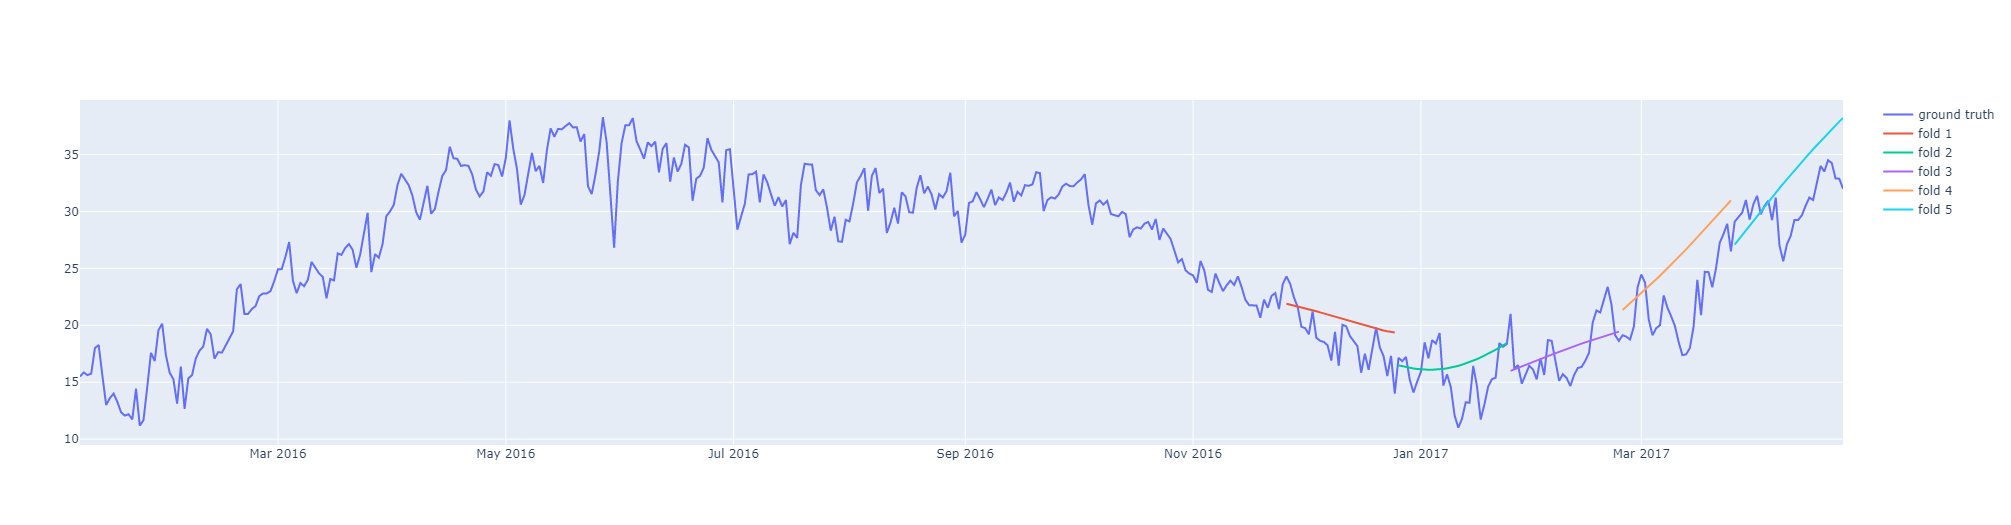

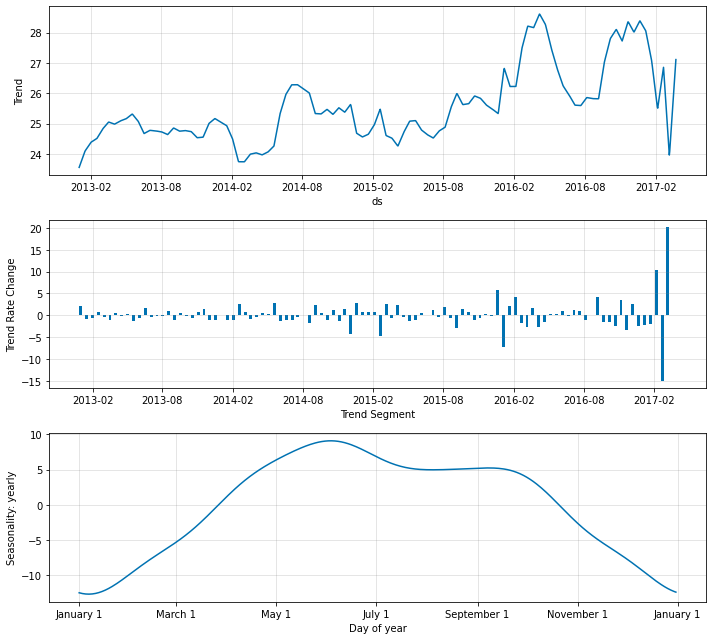

In [ ]:
params = p.plot_parameters()

In [ ]:
def get_forecast_and_plot(params, data_df, forecast_pct=0.02, gt_pct=0.2, into_future=False, forecast_steps=None):
  
  if forecast_steps:
    cut_off = forecast_steps
  else:
    cut_off = int(len(data_df) * forecast_pct)
  
  gt_offset = int(len(data_df) * (1- gt_pct))

  prophet = NeuralProphet(**params)

  if into_future:
    prophet.train(data_df)
    future = prophet.make_future_dataframe(data_df, periods=cut_off)
  else:
    prophet.fit(data_df[:-cut_off])
    future = prophet.make_future_dataframe(data_df[:-cut_off], periods=cut_off)

  forecast = prophet.predict(future)

  n_forecasts = params['n_forecasts']


  fig = go.Figure()
  fig.add_trace(go.Scatter(x=data_df[gt_offset:]['ds'], y=data_df[gt_offset:]['y'], mode='lines', name='ground truth'))
  if n_forecasts == 1:
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat1'], mode='lines', name='forecast'))
  else:
    y_hats = forecast[-n_forecasts:][[f'yhat{i}' for i in range(1, n_forecasts+1)]].sum(axis=1)
    fig.add_trace(go.Scatter(x=forecast[-n_forecasts:]['ds'], y=y_hats, mode='lines', name='forecast'))
  #return forecast, y_hats
  return prophet, forecast, fig

As I said above I'm going to turn off trend and replace it with autoregression and increase number of fourier terms for seasonality. 

Including autoregression component in the model makes the difference with number of steps forecasted at once. When using only trend and seasonality number of forecasting steps was irrelevant as seasonality is constant and trend is extrapolated linearly. With autoregression you can either forecast 30 steps at once or forecast 1 step use this forecast to predict next value then use these 2 values to predict the next one and so on. 

First I'm going to use model forecasting 30 steps at once using 90 days preceding first forecasting step

In [ ]:
params = {"weekly_seasonality": False, 'growth': 'off', 'n_forecasts': 30, 'n_lags': 90, 'yearly_seasonality': 16}

In [ ]:
metrics_train, metrics_test, fig1, p = crossvalidate(params=params, data_df=npdf, exp_name='exp1', forecast_steps=30, metrics_train=metrics_train, metrics_test=metrics_test)

In [ ]:
metrics_test

,MAE,RMSE,Params
baseline_f1,2.129260,2.498026,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f2,2.132218,2.653085,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f3,1.742873,2.118485,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f4,4.255717,4.869685,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f5,3.141903,3.665740,"{'weekly_seasonality': False, 'changepoints_ra..."
exp1_f1,1.844082,2.178524,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f2,1.809842,2.092964,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f3,1.951075,2.222790,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f4,2.277189,2.673797,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f5,2.463412,2.788336,"{'weekly_seasonality': False, 'growth': 'off',..."


Results are looking better but peaks and valleys predicted with ar part don't align well with ground truth

In [ ]:
fig1.show()

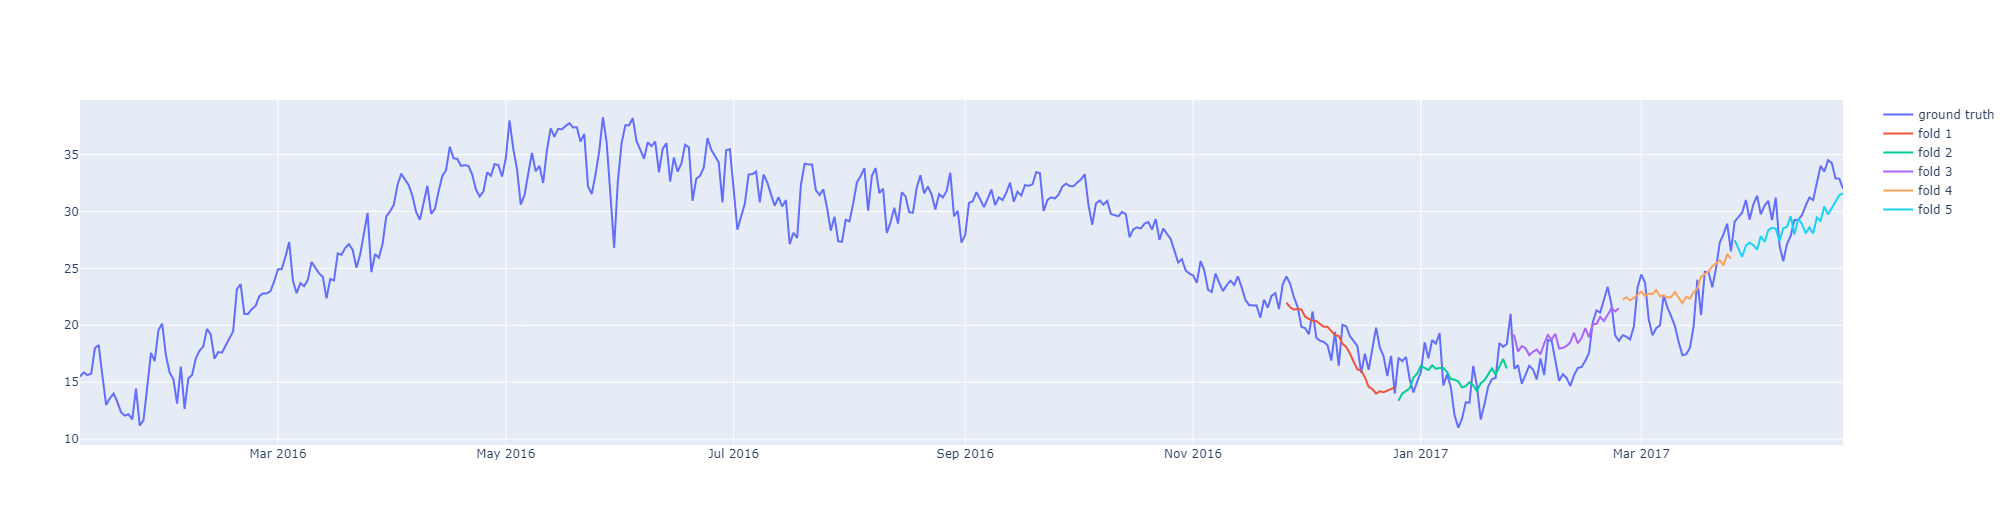

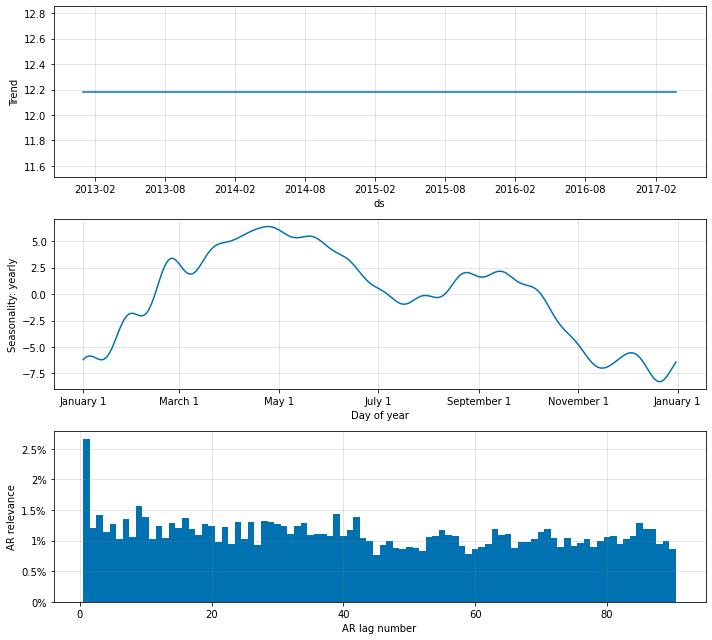

In [ ]:
param = p.plot_parameters()

To increase modeling power of ar component I'm going to increase number of hidden layers and number of neurons in it

In [ ]:
params = {"weekly_seasonality": False, 'growth': 'off', 'n_forecasts': 30, 'n_lags': 90, 'yearly_seasonality': 16, 'num_hidden_layers': 4, 'd_hidden': 200}

In [ ]:
metrics_train, metrics_test, fig2, p = crossvalidate(params=params, data_df=npdf, exp_name='exp2', forecast_steps=30, metrics_train=metrics_train, metrics_test=metrics_test)

In [ ]:
metrics_test

,MAE,RMSE,Params
baseline_f1,2.129260,2.498026,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f2,2.132218,2.653085,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f3,1.742873,2.118485,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f4,4.255717,4.869685,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f5,3.141903,3.665740,"{'weekly_seasonality': False, 'changepoints_ra..."
exp1_f1,1.844082,2.178524,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f2,1.809842,2.092964,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f3,1.951075,2.222790,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f4,2.277189,2.673797,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f5,2.463412,2.788336,"{'weekly_seasonality': False, 'growth': 'off',..."


Results didn't improve and in 4 out of 5 folds forecasts are smooth lines meaning that values predicted by ar component are 0 or almost 0. It's intresting that increasing number of layers and neurons caused this effect

In [ ]:
fig2.show()

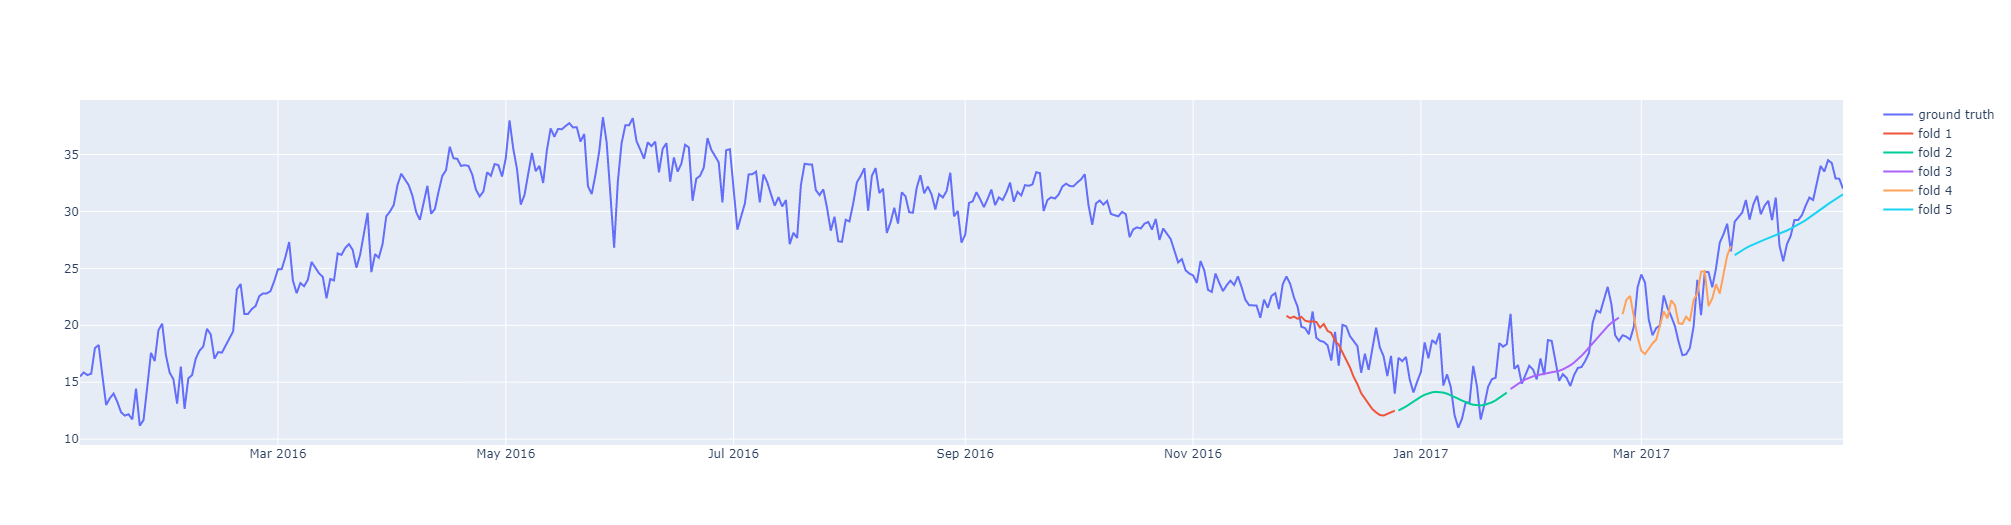

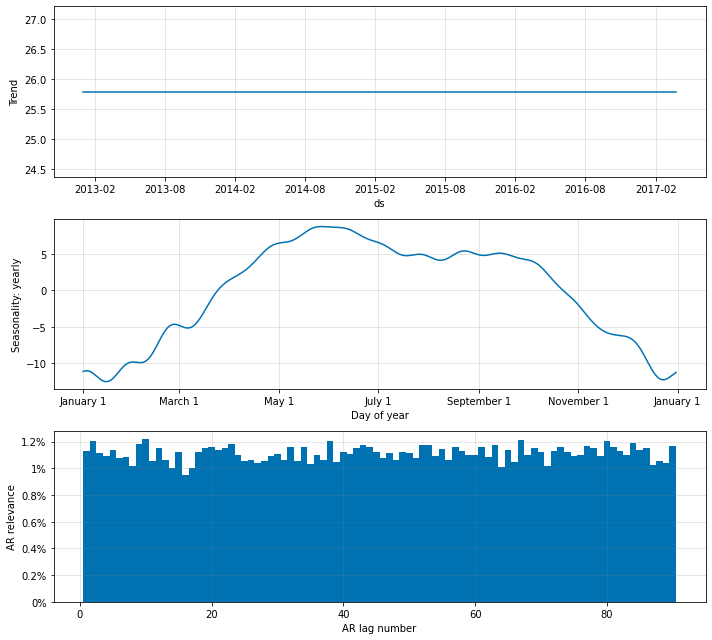

In [ ]:
param = p.plot_parameters()

Now I will change loss function from Huber to MSE because MSE is more sensitive to bigger errors and it might encourage ar component to learn to predict peaks and valleys instead of predicting a smooth line through the middle

In [ ]:
params = {"weekly_seasonality": False, 'growth': 'off', 'n_forecasts': 30, 'n_lags': 90, 'yearly_seasonality': 16, 'loss_func': 'MSE', 'num_hidden_layers': 4, 'd_hidden': 200}

In [ ]:
metrics_train, metrics_test, fig3, p = crossvalidate(params=params, data_df=npdf, exp_name='exp3', forecast_steps=30, metrics_train=metrics_train, metrics_test=metrics_test)

In [ ]:
metrics_test

,MAE,RMSE,Params
baseline_f1,2.129260,2.498026,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f2,2.132218,2.653085,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f3,1.742873,2.118485,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f4,4.255717,4.869685,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f5,3.141903,3.665740,"{'weekly_seasonality': False, 'changepoints_ra..."
exp1_f1,1.844082,2.178524,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f2,1.809842,2.092964,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f3,1.951075,2.222790,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f4,2.277189,2.673797,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f5,2.463412,2.788336,"{'weekly_seasonality': False, 'growth': 'off',..."


In [ ]:
metrics_train

,MAE,RMSE
baseline_f1,1.469755,1.869471
baseline_f2,1.463699,1.856173
baseline_f3,1.469955,1.862279
baseline_f4,1.443154,1.832553
baseline_f5,1.480809,1.880785
exp1_f1,1.548890,1.976136
exp1_f2,1.566127,1.997448
exp1_f3,1.572115,2.003786
exp1_f4,1.557533,1.976570
exp1_f5,1.577605,1.997931


Changing the loss function resulted in lower training errors. It also did encourage ar component to try model peaks and valleys but unfortunately they are opposites of what they should be. Model predict peaks where there are valleys in gt data and valleys where thera are peaks.

In [ ]:
fig3.show()

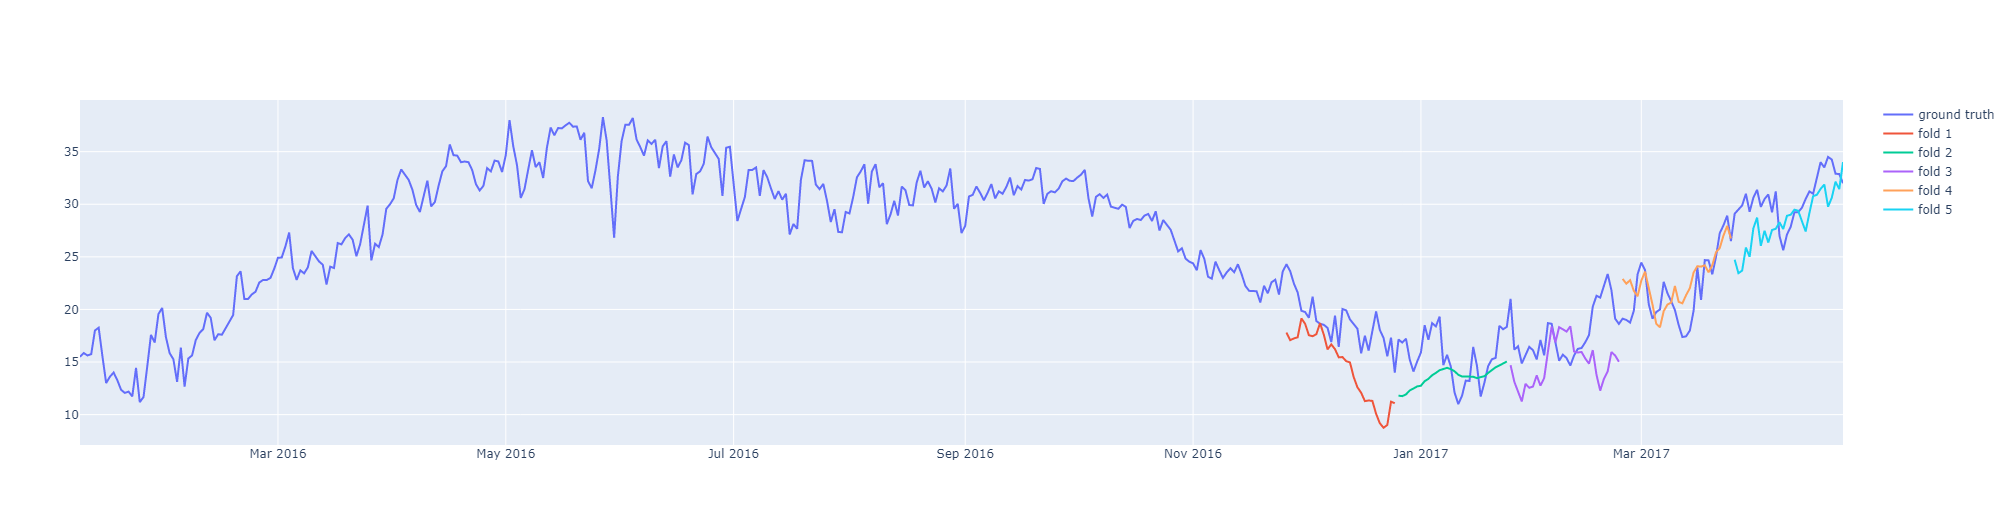

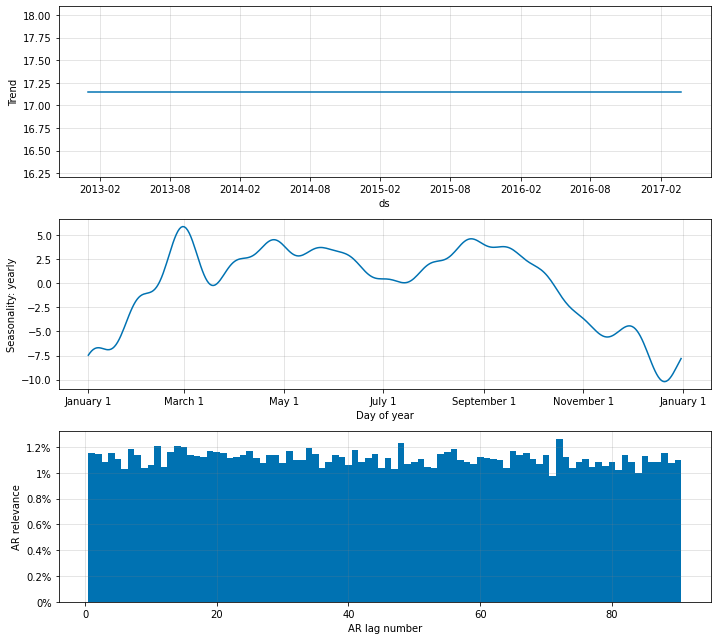

In [ ]:
param = p.plot_parameters()

Maybe looking at 90 preceding values is too much and model would get better results looking at shorter period. It's a longshot but let's test this hypothesis

In [ ]:
params = {"weekly_seasonality": False, 'growth': 'off', 'n_forecasts': 30, 'n_lags': 30, 'yearly_seasonality': 16, 'loss_func': 'MSE', 'num_hidden_layers': 4, 'd_hidden': 200}

In [ ]:
metrics_train, metrics_test, fig4, p = crossvalidate(params=params, data_df=npdf, exp_name='exp4', forecast_steps=30, metrics_train=metrics_train, metrics_test=metrics_test)

In [ ]:
metrics_test

,MAE,RMSE,Params
baseline_f1,2.129260,2.498026,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f2,2.132218,2.653085,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f3,1.742873,2.118485,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f4,4.255717,4.869685,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f5,3.141903,3.665740,"{'weekly_seasonality': False, 'changepoints_ra..."
exp1_f1,1.844082,2.178524,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f2,1.809842,2.092964,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f3,1.951075,2.222790,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f4,2.277189,2.673797,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f5,2.463412,2.788336,"{'weekly_seasonality': False, 'growth': 'off',..."


Using less laged observations didn't improve performance

In [ ]:
fig4.show()

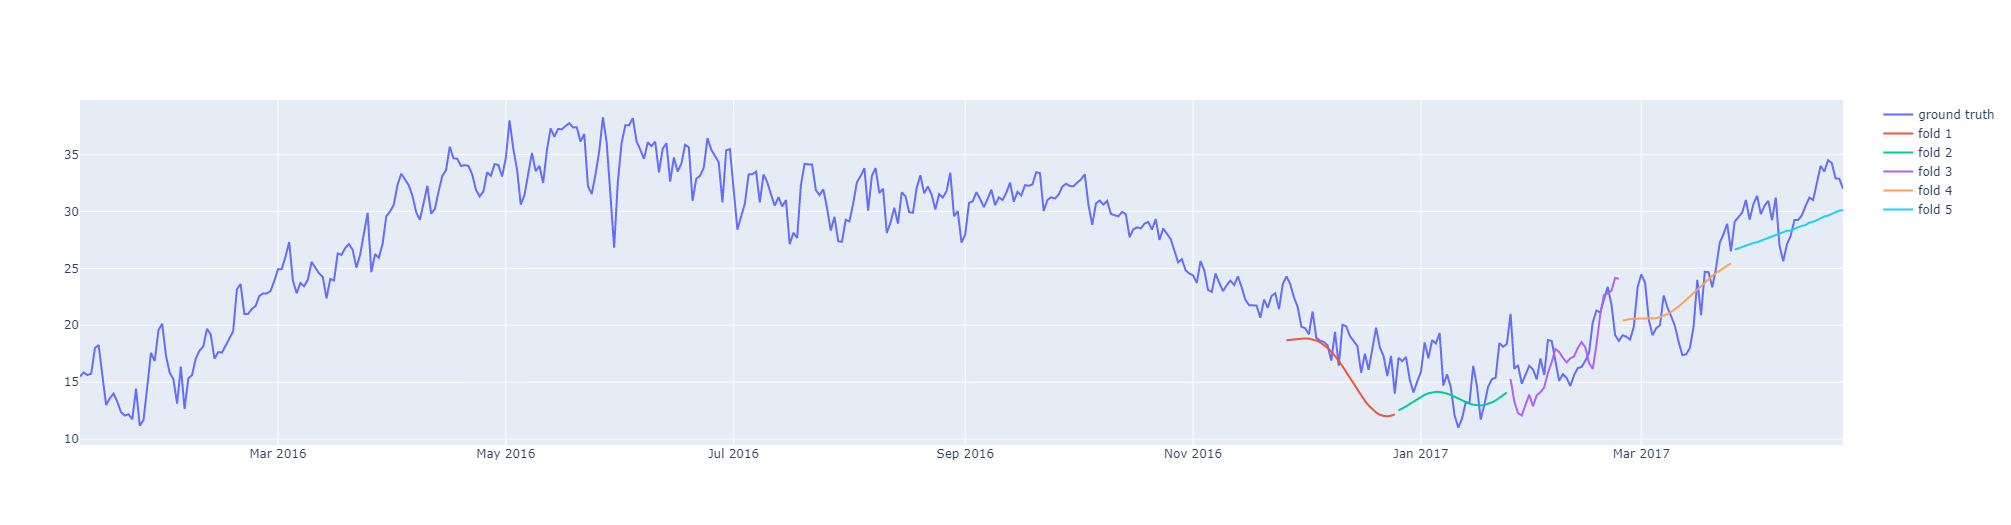

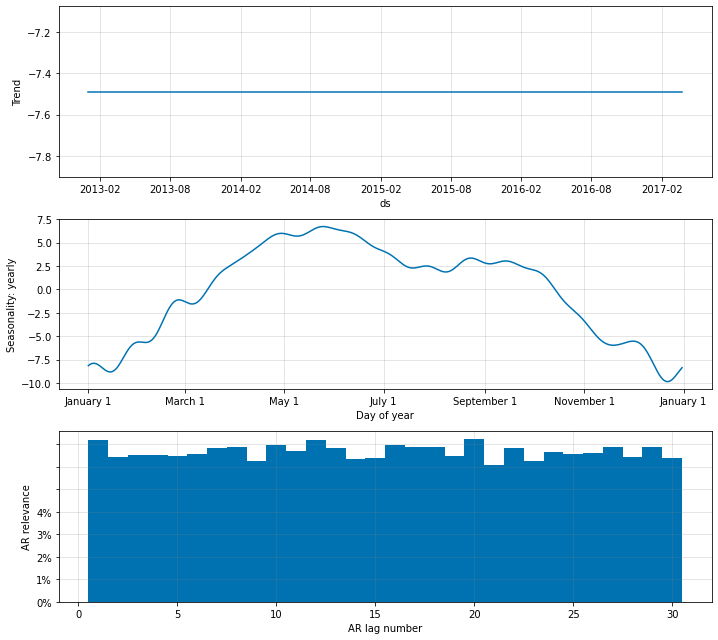

In [ ]:
param = p.plot_parameters()

Maybe using just seasonal component to predict smooth line that goes through the middle ingoring peaks and valleys is the best solution, let's try it out. For this experiment I'm going to use 26 furier terms for modeling seasonality

In [ ]:
params = {"weekly_seasonality": False, 'growth': 'off', 'n_forecasts': 30, 'yearly_seasonality': 26, 'loss_func':'MSE'}

In [ ]:
metrics_train = metrics_train[:25]
metrics_test = metrics_test[:25]

In [ ]:
metrics_train, metrics_test, fig5, p = crossvalidate(params=params, data_df=npdf, exp_name='exp5', forecast_steps=30, metrics_train=metrics_train, metrics_test=metrics_test)

In [ ]:
metrics_test

,MAE,RMSE,Params
baseline_f1,2.129260,2.498026,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f2,2.132218,2.653085,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f3,1.742873,2.118485,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f4,4.255717,4.869685,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f5,3.141903,3.665740,"{'weekly_seasonality': False, 'changepoints_ra..."
exp1_f1,1.844082,2.178524,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f2,1.809842,2.092964,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f3,1.951075,2.222790,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f4,2.277189,2.673797,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f5,2.463412,2.788336,"{'weekly_seasonality': False, 'growth': 'off',..."


Results using only seasonality are ok but they didn't beat exp1 which used autoregression

In [ ]:
fig5.show()

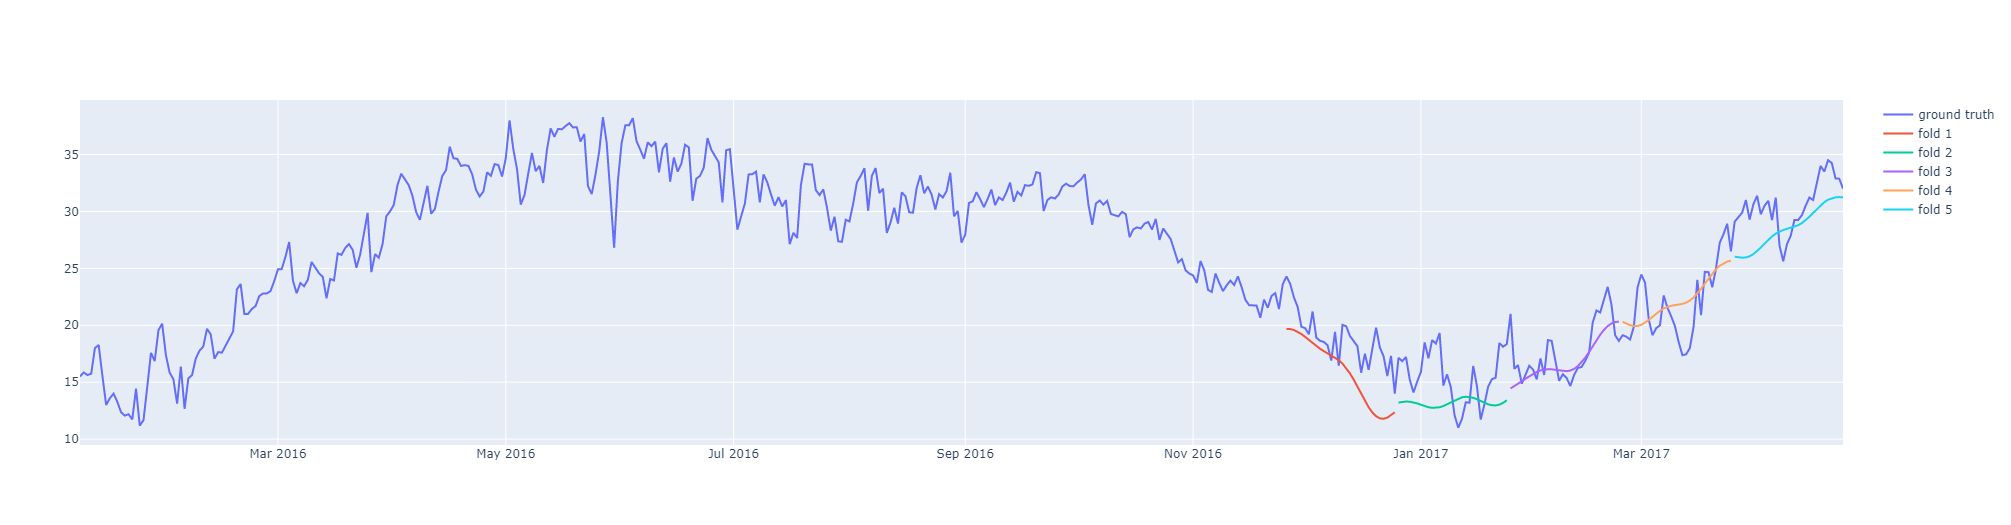

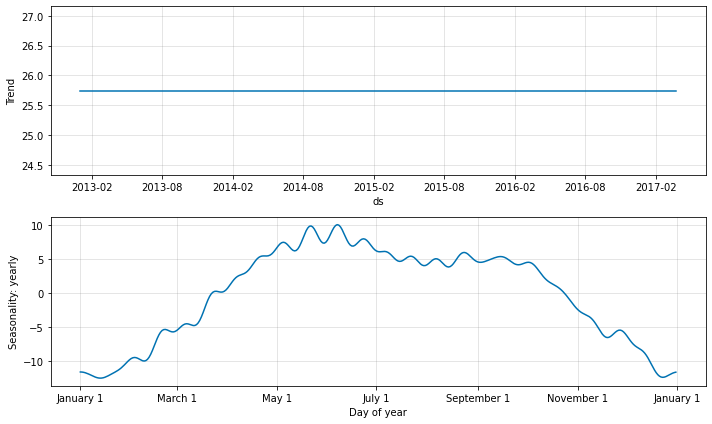

In [ ]:
param = p.plot_parameters()

Now let's try predicting only one step at a time using 14 preceding values

In [ ]:
params = {"weekly_seasonality": False, 'growth': 'off', 'n_forecasts': 1, 'n_lags': 14, 'yearly_seasonality': 16}

In [ ]:
metrics_train, metrics_test, fig6, p = crossvalidate(params=params, data_df=npdf, exp_name='exp6', forecast_steps=30, metrics_train=metrics_train, metrics_test=metrics_test)

In [ ]:
metrics_test

,MAE,RMSE,Params
baseline_f1,2.129260,2.498026,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f2,2.132218,2.653085,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f3,1.742873,2.118485,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f4,4.255717,4.869685,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f5,3.141903,3.665740,"{'weekly_seasonality': False, 'changepoints_ra..."
exp1_f1,1.844082,2.178524,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f2,1.809842,2.092964,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f3,1.951075,2.222790,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f4,2.277189,2.673797,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f5,2.463412,2.788336,"{'weekly_seasonality': False, 'growth': 'off',..."


These results are similar to the best ones I got predicting 30 steps at once. Let's do a couple more experiments increasing number of layers and neurons and using MSE loss 

In [ ]:
fig6.show()

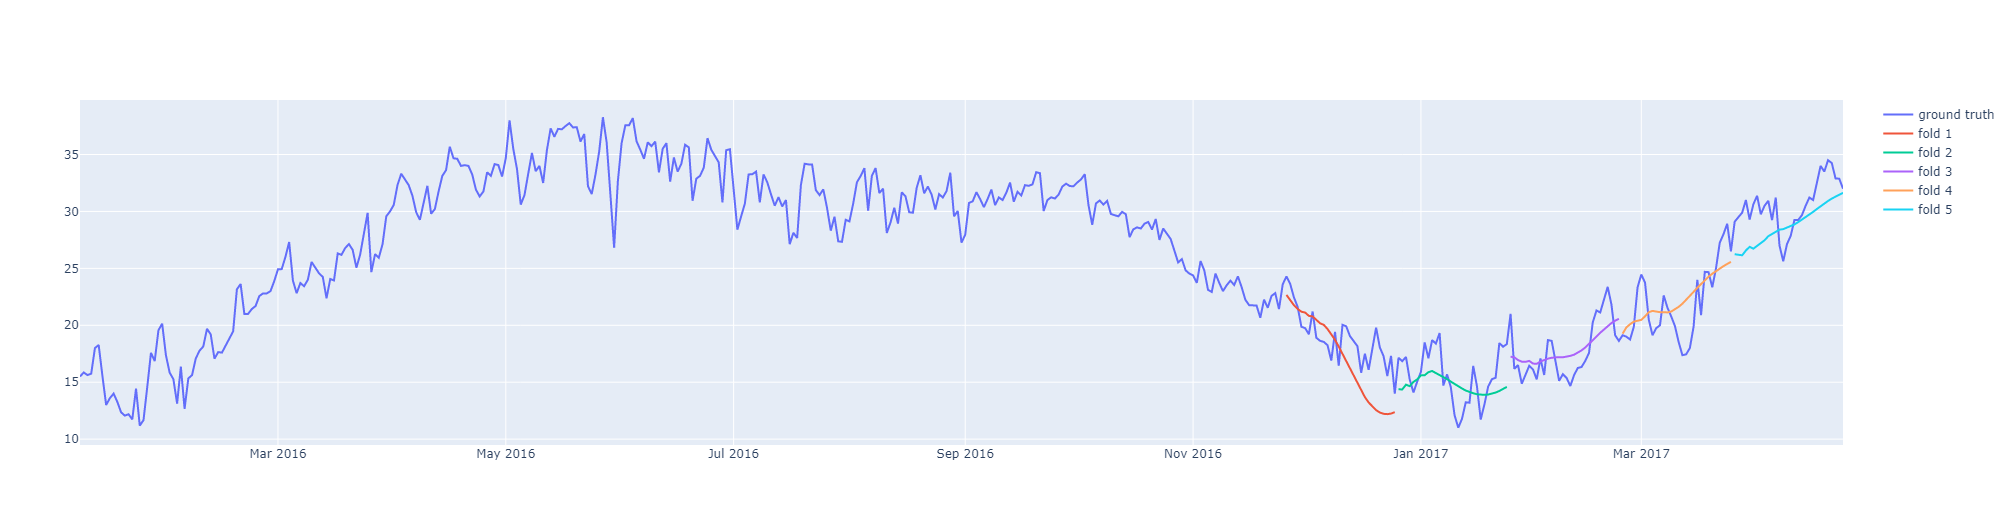

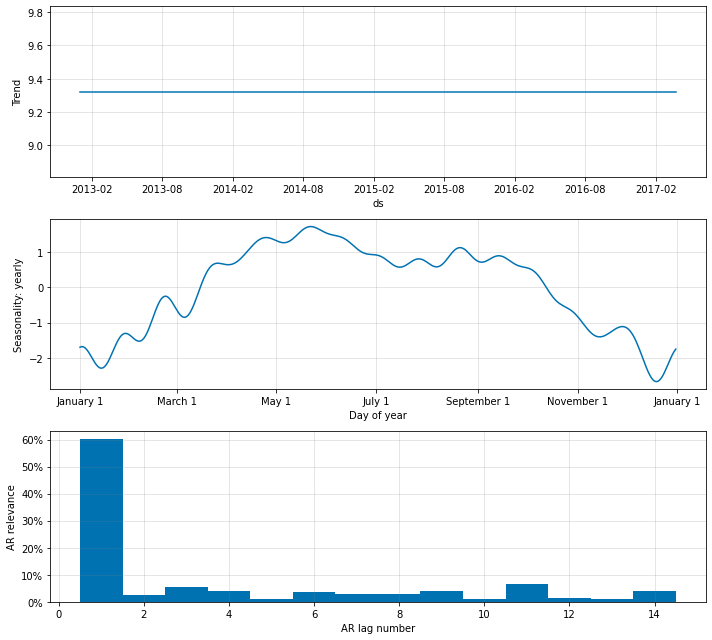

In [ ]:
param = p.plot_parameters()

In [ ]:
params = {"weekly_seasonality": False, 'growth': 'off', 'n_forecasts': 1, 'n_lags': 14, 'yearly_seasonality': 16, 'num_hidden_layers': 3, 'd_hidden': 60}

In [ ]:
metrics_train, metrics_test, fig7, p = crossvalidate(params=params, data_df=npdf, exp_name='exp7', forecast_steps=30, metrics_train=metrics_train, metrics_test=metrics_test)

In [ ]:
metrics_test

,MAE,RMSE,Params
baseline_f1,2.129260,2.498026,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f2,2.132218,2.653085,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f3,1.742873,2.118485,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f4,4.255717,4.869685,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f5,3.141903,3.665740,"{'weekly_seasonality': False, 'changepoints_ra..."
exp1_f1,1.844082,2.178524,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f2,1.809842,2.092964,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f3,1.951075,2.222790,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f4,2.277189,2.673797,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f5,2.463412,2.788336,"{'weekly_seasonality': False, 'growth': 'off',..."


In [ ]:
fig7.show()

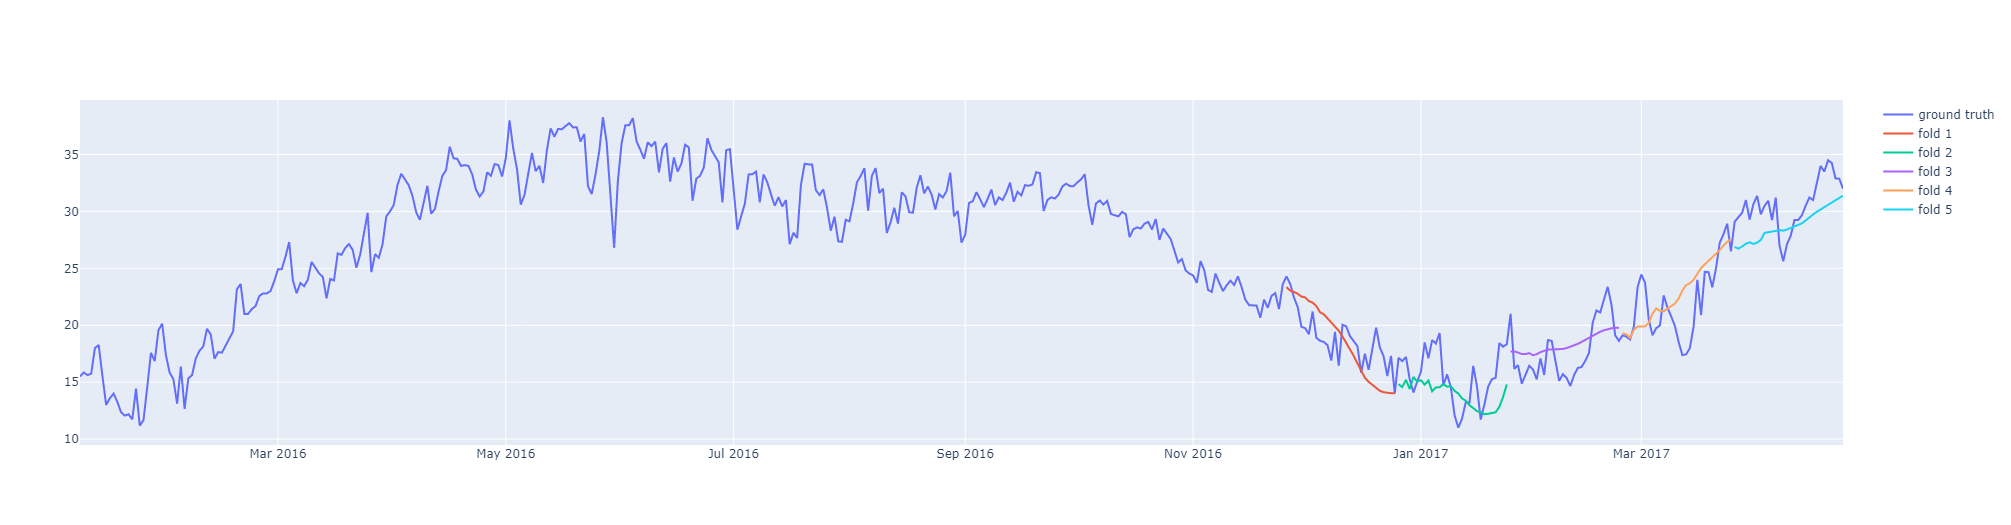

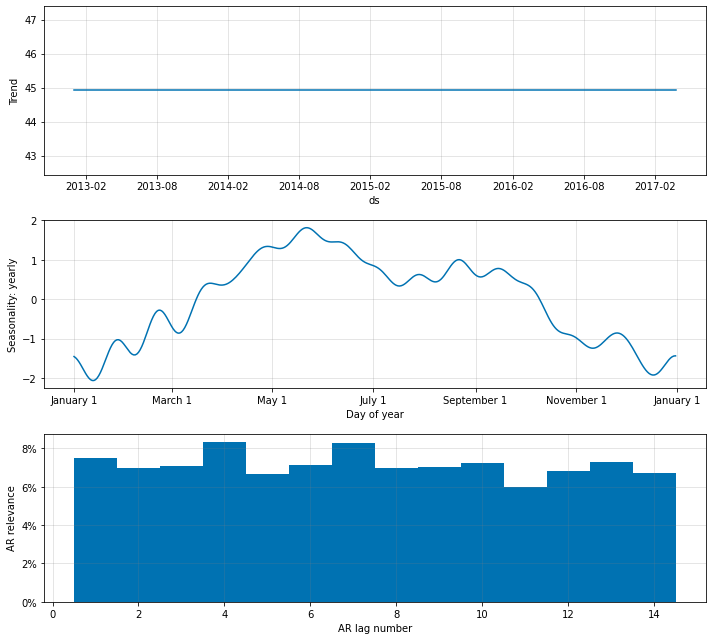

In [ ]:
param = p.plot_parameters()


In [ ]:
params = {"weekly_seasonality": False, 'growth': 'off', 'n_forecasts': 1, 'n_lags': 14, 'yearly_seasonality': 16, 'num_hidden_layers': 3, 'd_hidden': 60, 'loss_func': 'MSE'}

In [ ]:
metrics_train, metrics_test, fig8, p = crossvalidate(params=params, data_df=npdf, exp_name='exp8', forecast_steps=30, metrics_train=metrics_train, metrics_test=metrics_test)

In [ ]:
metrics_test

,MAE,RMSE,Params
baseline_f1,2.129260,2.498026,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f2,2.132218,2.653085,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f3,1.742873,2.118485,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f4,4.255717,4.869685,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f5,3.141903,3.665740,"{'weekly_seasonality': False, 'changepoints_ra..."
exp1_f1,1.844082,2.178524,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f2,1.809842,2.092964,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f3,1.951075,2.222790,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f4,2.277189,2.673797,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f5,2.463412,2.788336,"{'weekly_seasonality': False, 'growth': 'off',..."


Metrics from some experiments are very similar so I will calculate mean and standard deviation for each experiment to pick the most reliable model

In [ ]:
fig8.show()

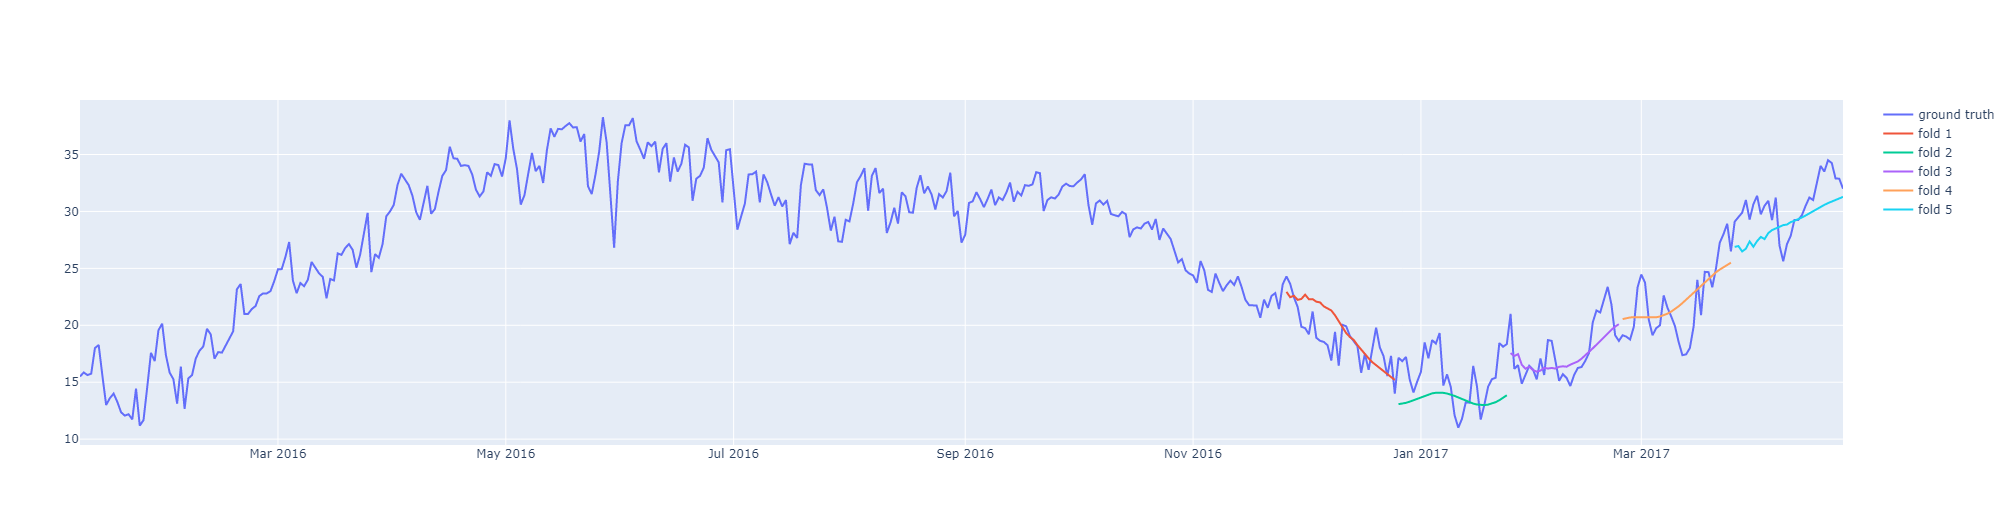

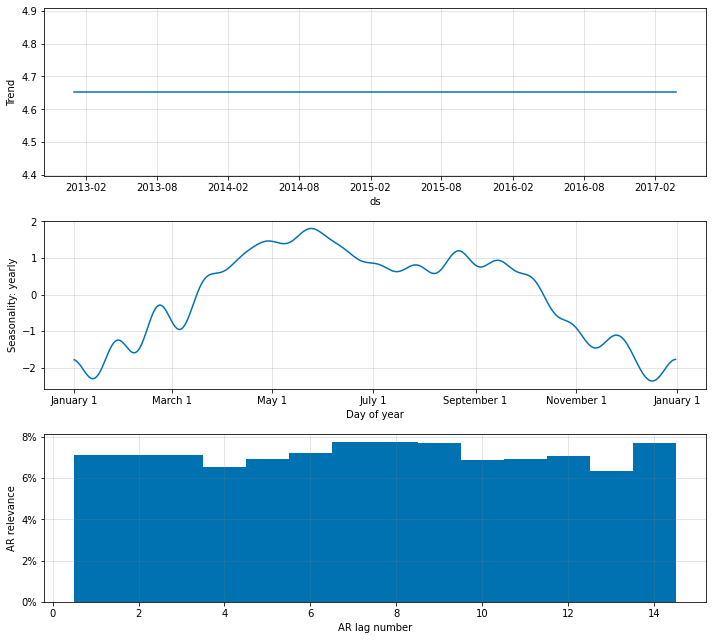

In [ ]:
param = p.plot_parameters()

In [ ]:
metrics_train.to_csv('/content/drive/MyDrive/time_series_data/metric_train.csv')
metrics_test.to_csv('/content/drive/MyDrive/time_series_data/metrics_test.csv')

In [ ]:
metrics_test = pd.read_csv('/content/drive/MyDrive/time_series_data/metrics_test.csv', index_col=[0])

In [ ]:
metrics_test

,MAE,RMSE,Params
baseline_f1,2.129260,2.498026,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f2,2.132218,2.653085,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f3,1.742873,2.118485,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f4,4.255717,4.869685,"{'weekly_seasonality': False, 'changepoints_ra..."
baseline_f5,3.141903,3.665740,"{'weekly_seasonality': False, 'changepoints_ra..."
exp1_f1,1.844082,2.178524,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f2,1.809842,2.092964,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f3,1.951075,2.222790,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f4,2.277189,2.673797,"{'weekly_seasonality': False, 'growth': 'off',..."
exp1_f5,2.463412,2.788336,"{'weekly_seasonality': False, 'growth': 'off',..."


In [ ]:
def transform_metrics(metrics, k_folds):
  num_exp = int(len(metrics)/k_folds)
  transformed_metrics = pd.DataFrame(columns=['MAE_mean', 'MAE_std', 'RMSE_mean', 'RMSE_std', 'Params'])
  for i in range(num_exp):
    i_start = i*k_folds
    i_end = i_start+k_folds
    mae_mean = metrics[i_start:i_end]['MAE'].mean()
    mae_std = metrics[i_start:i_end]['MAE'].std()
    rmse_mean = metrics[i_start:i_end]['RMSE'].mean()
    rmse_std = metrics[i_start:i_end]['RMSE'].std()
    params = metrics[i_start:i_start+1]['Params'].to_numpy()[0]
    temp_dict = {'MAE_mean': mae_mean, 'MAE_std': mae_std, 'RMSE_mean': rmse_mean, 'RMSE_std': rmse_std, "Params": params}
    transformed_metrics = pd.concat([transformed_metrics, pd.DataFrame(temp_dict, index=[metrics[i_start:i_start+1].index[0]])])
  return transformed_metrics

Model from experiment number 7 achieved third best results on MAE of 2.06 degrees being only 0.11 degrees behind the best one but had the lowest standard deviation. On RMSE it achieved fourth best result of 2.46 also being 0.11 behind the best score and it had the lowest standard deviation. 

Average error of 2 degrees on 30 day weather forecast using only previous temperature measures in my opinion is a good result.

I'm going to train neural prophet with parameters from 7th experiment, forecast with it and export it as final model.

In [ ]:
metrics_summary = transform_metrics(metrics_test, 5)
metrics_summary

,MAE_mean,MAE_std,RMSE_mean,RMSE_std,Params
baseline_f1,2.680394,1.021986,3.161004,1.113409,"{'weekly_seasonality': False, 'changepoints_ra..."
exp1_f1,2.069120,0.287472,2.391282,0.316273,"{'weekly_seasonality': False, 'growth': 'off',..."
exp2_f1,2.281624,0.437825,2.723531,0.456562,"{'weekly_seasonality': False, 'growth': 'off',..."
exp3_f1,2.981951,0.918395,3.561767,1.083270,"{'weekly_seasonality': False, 'growth': 'off',..."
exp4_f1,2.475329,0.360020,2.911650,0.428353,"{'weekly_seasonality': False, 'growth': 'off',..."
exp5_f1,2.304380,0.651735,2.781896,0.670162,"{'weekly_seasonality': False, 'growth': 'off',..."
exp6_f1,2.028443,0.371911,2.397269,0.463282,"{'weekly_seasonality': False, 'growth': 'off',..."
exp7_f1,2.066753,0.139347,2.460122,0.281708,"{'weekly_seasonality': False, 'growth': 'off',..."
exp8_f1,1.955216,0.419782,2.350599,0.443109,"{'weekly_seasonality': False, 'growth': 'off',..."
exp9_f1,2.363035,0.798498,2.790866,0.791973,"{'weekly_seasonality': False, 'growth': 'off',..."


In [ ]:
params = ast.literal_eval(metrics_summary.loc['exp7_f1']['Params'])
params


{'weekly_seasonality': False,
 'growth': 'off',
 'n_forecasts': 1,
 'n_lags': 14,
 'yearly_seasonality': 16,
 'num_hidden_layers': 3,
 'd_hidden': 60}

In [ ]:
final_model = NeuralProphet(**params)
final_model.fit(npdf, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.937% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.937% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 169
INFO:NP.config:Auto-set epochs to 169


  0%|          | 0/130 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.99E-04, min: 4.25E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.99E-04, min: 4.25E-01


  0%|          | 0/130 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.53E+00, min: 1.17E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.53E+00, min: 1.17E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.25E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 4.25E-02
Epoch[169/169]: 100%|██████████| 169/169 [00:27<00:00,  6.15it/s, SmoothL1Loss=0.0013, MAE=1.13, RMSE=1.48, Loss=0.000963, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,Loss,RegLoss
0,0.327180,19.784615,24.559736,0.244724,0.0
1,0.202538,15.280299,18.841241,0.151779,0.0
2,0.157764,13.374372,16.425772,0.118822,0.0
3,0.112752,11.276690,13.865055,0.084390,0.0
4,0.079564,9.364206,11.574877,0.059409,0.0
...,...,...,...,...,...
164,0.001307,1.132951,1.479496,0.000970,0.0
165,0.001302,1.133941,1.480694,0.000967,0.0
166,0.001300,1.132686,1.480668,0.000965,0.0
167,0.001299,1.130936,1.475169,0.000964,0.0


In [ ]:
def forecast_and_plot(model, historical_data, zoom_pct=0.5, forecast_steps=30, autoregressive=True):
  fig = go.Figure()
  gt_offset = int(len(historical_data) * (1- zoom_pct))

  fig.add_trace(go.Scatter(x=historical_data[gt_offset:]['ds'], y=historical_data[gt_offset:]['y'], mode='lines', name='ground truth'))

  if autoregressive == False:
    future = model.make_future_dataframe(historical_data, periods=forecast_steps)
    forecast = model.predict(future)
    preds = forecast[-forecast_steps:][[f'yhat{i}' for i in range(1, 31)]].sum(axis=1)
    ds = forecast[-forecast_steps:]['ds']
  else:
    future = model.make_future_dataframe(historical_data, periods=1)
    preds = []
    ds = []
    for _ in range(forecast_steps):
      forecast = model.predict(future)
      preds.append(forecast.iloc[-1]['yhat1'])
      ds.append(forecast.iloc[-1]['ds'])
      make_future1 = forecast[:-1][['ds', 'y']]
      make_future2 = forecast[-1:][['ds', 'yhat1']]
      make_future2.columns = make_future1.columns
      make_future = pd.concat([make_future1, make_future2])
      future = model.make_future_dataframe(make_future, periods=1)
    
  fig.add_trace(go.Scatter(x=ds, y=preds, mode='lines', name='forecast'))

  forecast_df = pd.DataFrame(index=[ds])
  forecast_df['y'] = preds
  return forecast_df, fig

In [ ]:
forecast, fig = forecast_and_plot(final_model, npdf)

In [ ]:
forecast

In [ ]:
fig.show()

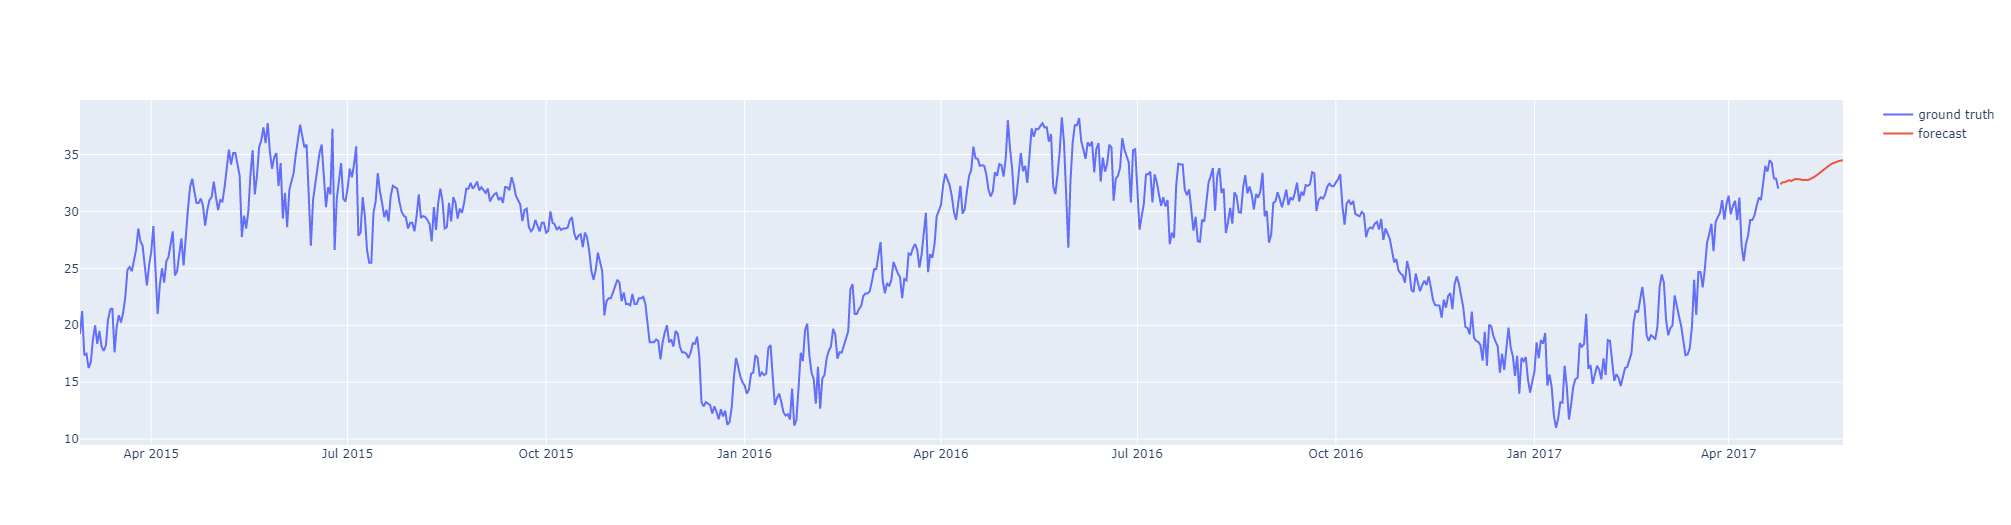

In [ ]:
with open('/content/drive/MyDrive/time_series_data/neural_prophet_model.p', 'wb') as file:
  pickle.dump(final_model, file)